# Bag of words

--------

In [1]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)   

In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import gensim
import scikitplot
import scikitplot.plotters as skplt
import nltk
from xgboost import XGBClassifier
import os,re
import seaborn as sns

# Feature engineering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.utils import shuffle

# Cross-val
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier

# metrics
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import confusion_matrix



### 1. Get the data

In [4]:
train = pd.read_csv('data.csv')

In [5]:
train.head()

,Unnamed: 0,Label,Text
0,0,MISC,The Minimum Description Length principle for o...
1,1,MISC,"If the underlying model class is discrete, the..."
2,2,MISC,"For MDL, in general one can only have loss bou..."
3,3,AIMX,We show that this is even the case if the mode...
4,4,OWNX,We derive a new upper bound on the prediction ...


### 2. Prepare Bag of Words

In [6]:
count_vectorizer = CountVectorizer(analyzer="word",
                                   tokenizer=nltk.word_tokenize,
                                   preprocessor=None,
                                   stop_words='english',
                                   max_features=None)  
bag_of_words = count_vectorizer.fit_transform(train['Text'])

##### Use Array Bag of Word

In [7]:
bow = bag_of_words.toarray()

##### Use Truncated Array Bag of Words

In [8]:
svd = TruncatedSVD(n_components=200, n_iter=25, random_state=12)
t_bow = svd.fit_transform(bag_of_words)

#### Encoding of target

In [9]:
label = train['Label'].values.ravel()

# One Hot encoding
ohe_label = pd.get_dummies(label).values

# Label Incoding
lbe_label =  preprocessing.LabelEncoder().fit(label).transform(label)

### 3. Shuffle and Split Data

In [10]:
def get_train_test_data(features,target):

    #shuffle the data
    features, target = shuffle(features, target)

    # Split the 'features' and 'income' data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target, 
                                                    test_size = 0.2,
                                                    random_state = 0)
    # Show the results of the split
    print ("Training set has {} samples.".format(X_train.shape[0]))
    print ("Testing set has {} samples.".format(X_test.shape[0]))
    return X_train, X_test, y_train, y_test

### 4. Initial Model Evaluation

#### 4.1 Pipeline

In [11]:

def train_predict(learner, X_train, y_train, X_test, y_test, disp_cmat=False): 
    '''
    inputs:
        learner: the learning algorithm to be trained and predicted on
        sample_size: the size of samples (number) to be drawn from training set
        X_train: features training set
        y_train: income training set
        X_test: features testing set
        y_test: income testing set
    '''
    
    results = {}
    c_matrix = {}
   
    
    #  Fit the learner to the training data using slicing with 'sample_size'
    start = time()  # Get start time  -------->
    learner.fit(X_train, y_train)
    end = time()    # Get end time      <--------

    
    
    #  Calculate the training time
    results['train_time'] = end-start
        
        
    #  Get the predictions on the test set,
    #  then get predictions on the training samples
    start = time()  # Get start time    ------->
    predictions_test = learner.predict(X_test)
    predict_prob_test = learner.predict_proba(X_test)
    predictions_train = learner.predict(X_train)
    predict_prob_train = learner.predict_proba(X_train)
    end = time()    # Get end time        <-------
    
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
           
        
    # Compute accuracy on the training samples
    results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Log loss on the the  training samples
    results['logloss_train'] = log_loss(y_train, predict_prob_train)
        
    # Log loss on the test set
    results['logloss_test'] = log_loss(y_test, predict_prob_test)
    
    # Prepare Confusion Matix
    c_matrix['c_mat'] = confusion_matrix(y_test, predictions_test)
      
        
    #classification report
    #report['classification_report'] = classification_report(y_test, predictions_test)
    
        
    #f1 score
    #results['f1_score'] = f1_score(y_test, predictions_test, average='macro')
    
    
    #results['precission'] = precision_score(y_test, predictions_test, average=None)
    #results['recall'] = recall_score(y_test, predictions_test, average=None)   
    
        
    # Success
    print ("{} trained on {} train data.".format(learner.__class__.__name__,X_train.shape[0]))
        
    if disp_cmat:
        scikitplot.metrics.plot_confusion_matrix(y_test,predictions_test)
        
    # Return the results
    return results, c_matrix 

#### Get bag of words train and test data

In [33]:
 X_train, X_test, y_train, y_test = get_train_test_data(bow,lbe_label)

Training set has 2493 samples.
Testing set has 624 samples.


#### A sample run

GaussianNB trained on 2493 train data.


({'acc_test': 0.8141025641025641,
  'acc_train': 0.88407541115122346,
  'logloss_test': 6.4206699708516428,
  'logloss_train': 4.003893452919856,
  'pred_time': 1.2921128273010254,
  'train_time': 0.17722201347351074},
 {'c_mat': array([[ 29,   0,   0,   0,   2],
         [  1,   5,   0,   2,   2],
         [  1,   0,  27,   8,   2],
         [  4,   0,  31, 315,  32],
         [ 16,   1,   3,  11, 132]])})

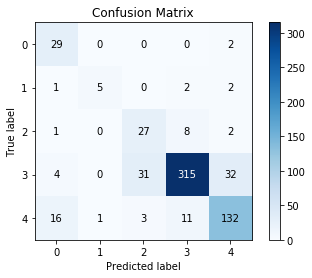

In [37]:
gnb = GaussianNB()
train_predict( gnb, X_train, y_train, X_test, y_test, disp_cmat=True)

#### 4.2  Evaluation of multiple models

In [38]:

# Initialize the three models
clf_A = MultinomialNB() 


clf_B = LogisticRegression(random_state=101)


clf_C = SVC(kernel='rbf', probability=True)


clf_D = KNeighborsClassifier(n_neighbors=5)


clf_E = RandomForestClassifier(n_estimators=500,
                               max_depth=5,
                               verbose=0)

clf_F = GradientBoostingClassifier()


clf_G = XGBClassifier(max_depth=4,
                      objective='multi:softprob',
                      learning_rate=0.8)

                                

# Collect results on the learners
results1 = {}
c_matrix1 = {}


for clf in [clf_A, clf_B, clf_C, clf_D, clf_E, clf_F, clf_G]:
    clf_name = clf.__class__.__name__
    results1[clf_name] = {}
    c_matrix1[clf_name] = {}
    
   

    results1[clf_name], c_matrix1[clf_name]  = \
                    train_predict(clf, X_train, y_train, X_test, y_test)
   

MultinomialNB trained on 2493 train data.
LogisticRegression trained on 2493 train data.
SVC trained on 2493 train data.
KNeighborsClassifier trained on 2493 train data.
RandomForestClassifier trained on 2493 train data.
GradientBoostingClassifier trained on 2493 train data.
XGBClassifier trained on 2493 train data.


#### 4.3 Results

In [46]:
result1_df = pd.DataFrame(results1).transpose()
models = list(result1_df.index)
result1_df 

,acc_test,acc_train,logloss_test,logloss_train,pred_time,train_time
GradientBoostingClassifier,0.778846,0.854793,0.637017,0.515570,0.170452,190.991401
KNeighborsClassifier,0.714744,0.849579,1.772694,0.394607,74.472953,0.415237
LogisticRegression,0.860577,0.930606,0.441870,0.229286,0.101033,0.098748
MultinomialNB,0.815705,0.897312,0.983781,0.404172,0.101547,0.060106
RandomForestClassifier,0.612179,0.578821,0.976549,0.979120,0.568323,3.893883
SVC,0.612179,0.578821,0.563751,0.431789,44.879489,117.086140
XGBClassifier,0.852564,0.931408,0.478965,0.217681,0.370616,28.356611


#### 4.4 Comparision of Results :  Accuracy, Log Loss  and Time

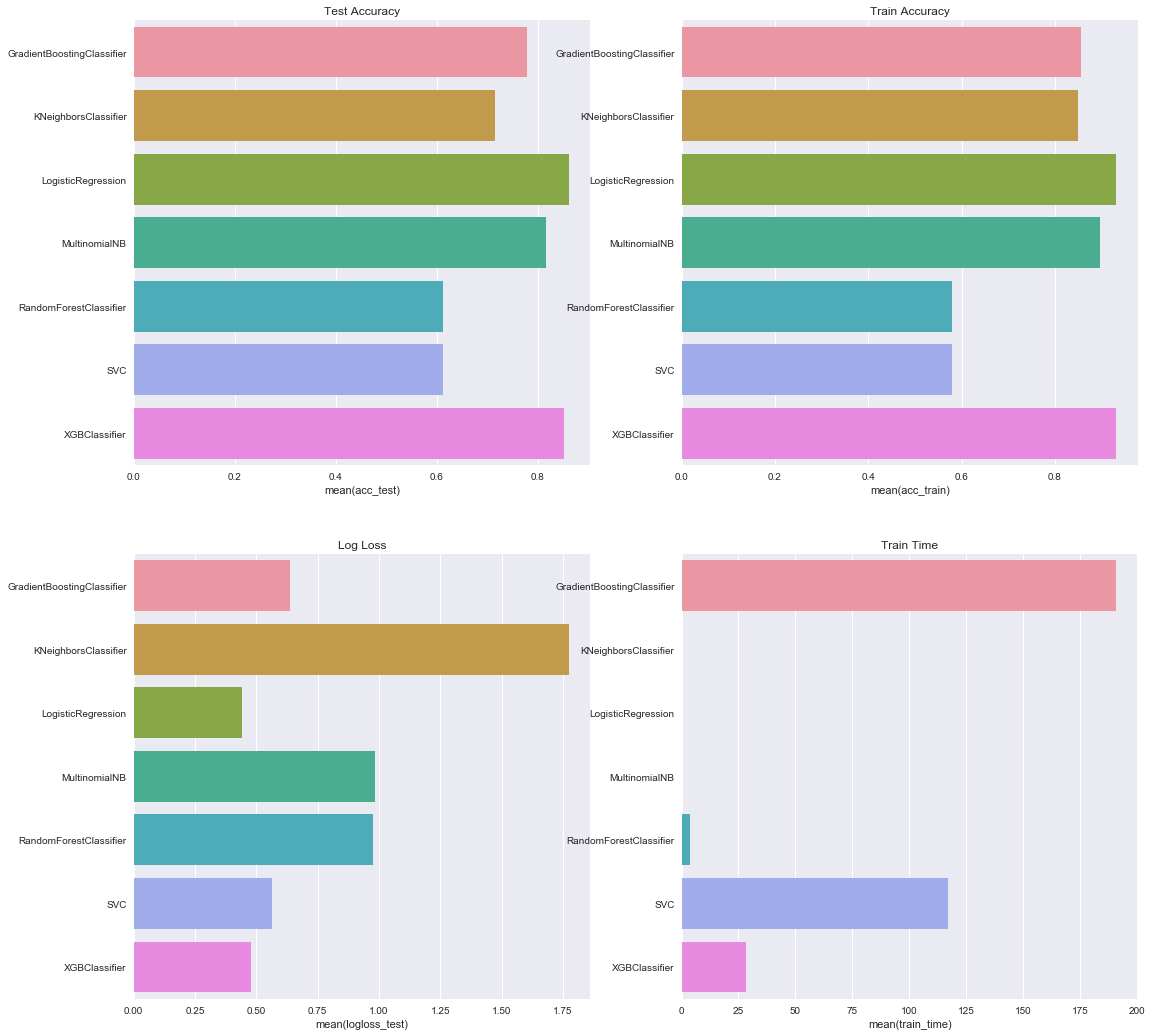

In [47]:
import seaborn as sns
plt.figure(figsize = (18,18))
plt.subplot(2,2,1)
sns.barplot(x="acc_test",y = models, data=result1_df);
plt.title('Test Accuracy')
plt.subplot(2,2,2)
sns.barplot(x="acc_train",y = models, data=result1_df);
plt.title('Train Accuracy')
plt.subplot(2,2,3)
sns.barplot(x="logloss_test",y = models, data=result1_df);
plt.title('Log Loss')
plt.subplot(2,2,4)
sns.barplot(x="train_time",y = models, data=result1_df);
plt.title('Train Time')
plt.show()

#### 4.5 Confusion Matrices

In [48]:
lb = np.unique(train['Label'].values.ravel())
cmatrix1 = pd.DataFrame(c_matrix1).transpose()

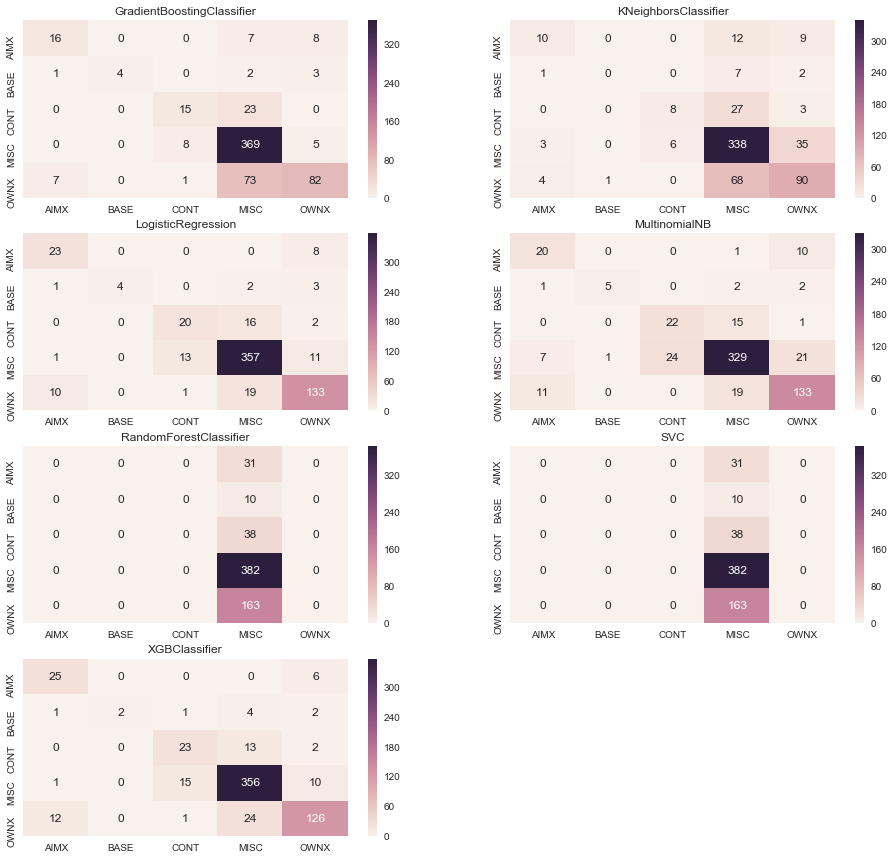

In [50]:
plt.figure(figsize = (16,15))
for k in range(len(models)):
    mat = cmatrix1['c_mat'][k]
    matt = pd.DataFrame(mat, columns = lb, index = lb)
    plt.subplot(4,2,k+1)
    plt.title(models[k])
    sns.heatmap(matt, annot=True, fmt="d")
plt.show()

-----

### 5.  Tuning

#### 5.1. Parameter Tuning For Best Classifier: XGBoost

In [34]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


# Initialize the classifier
clf = XGBClassifier()


# Create the parameters list you wish to tune
tuned_parameters = [{'max_depth':[3,4], 'learning_rate' : [0.01,0.05,0.1,0.5,0.8]}]
                     


# Make an logloss_score scoring object
scorer = make_scorer(accuracy_score)


# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, tuned_parameters, cv =4, scoring=scorer)


# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)


# Get the estimator
best_clf = grid_fit.best_estimator_


# Make predictions using the unoptimized and model
predictions_test = (clf.fit(X_train, y_train)).predict(X_test)



best_predictions = best_clf.predict(X_test)



# Report the before-and-afterscores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions_test)))



print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))


Unoptimized model
------
Accuracy score on testing data: 0.7452

Optimized Model
------
Final accuracy score on the testing data: 0.8558


In [35]:
best_clf.get_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.8,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': -1,
 'objective': 'multi:softprob',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': True,
 'subsample': 1}

-------------

#### 5.2.   Parameter Tuning For Best Classifier: Logistic Regression

In [65]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score,f1_score


# Initialize the classifier
clf = LogisticRegression()


# Create the parameters list you wish to tune
tuned_parameters = {'solver': ['liblinear','lbfgs'],
              'C': [0.1,0.5,0.7,1.0],
              'random_state': [101,101,101]}
                     


# Make an logloss_score scoring object
scorer = make_scorer(accuracy_score)


# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, tuned_parameters, cv =4, scoring=scorer)


# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)


# Get the estimator
best_clf = grid_fit.best_estimator_


# Make predictions using the unoptimized and model
predictions_test = (clf.fit(X_train, y_train)).predict(X_test)



best_predictions = best_clf.predict(X_test)



# Report the before-and-afterscores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions_test)))



print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))


Unoptimized model
------
Accuracy score on testing data: 0.8574

Optimized Model
------
Final accuracy score on the testing data: 0.8558


In [66]:
best_clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': 101,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### 6. Using Neural Network

#### 6.1 Simple Neural Networks with  Bag of Words

In [13]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
import os

In [14]:
X_train, X_test, y_train, y_test = get_train_test_data(bow,lbe_label)

Training set has 2493 samples.
Testing set has 624 samples.


In [15]:
y_train = np_utils.to_categorical(y_train)
num_classes = y_train.shape[1]
input_dim = X_train.shape[1]

In [18]:
# Model saving callback
ckpt_callback = ModelCheckpoint('bof_nn', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')


model = Sequential()
model.add(Dense(500, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(300, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(100, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               2019000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               150300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
__________

In [19]:
# we'll use categorical xent for the loss, and RMSprop as the optimizer
model.compile(loss='categorical_crossentropy',\
              optimizer='rmsprop',\
              metrics=['accuracy'])

In [28]:
print("Training...")
history = model.fit(X_train,\
          y_train,\
          nb_epoch=40,\
          batch_size=64,\
          validation_split=0.3,\
          verbose=2)

Training...
Train on 1745 samples, validate on 748 samples
Epoch 1/40


/Users/dibakarsigdel/anaconda/envs/carnd-term1/lib/python3.5/site-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


1s - loss: 0.1078 - acc: 0.9370 - val_loss: 1.2288 - val_acc: 0.8663
Epoch 2/40
1s - loss: 0.0971 - acc: 0.9427 - val_loss: 1.2928 - val_acc: 0.8623
Epoch 3/40
1s - loss: 0.1122 - acc: 0.9467 - val_loss: 1.2874 - val_acc: 0.8516
Epoch 4/40
1s - loss: 0.0976 - acc: 0.9444 - val_loss: 1.3842 - val_acc: 0.8623
Epoch 5/40
1s - loss: 0.1067 - acc: 0.9393 - val_loss: 1.4229 - val_acc: 0.8596
Epoch 6/40
1s - loss: 0.0944 - acc: 0.9398 - val_loss: 1.3437 - val_acc: 0.8623
Epoch 7/40
1s - loss: 0.0948 - acc: 0.9433 - val_loss: 1.3887 - val_acc: 0.8570
Epoch 8/40
1s - loss: 0.0976 - acc: 0.9450 - val_loss: 1.2284 - val_acc: 0.8663
Epoch 9/40
1s - loss: 0.0983 - acc: 0.9450 - val_loss: 1.4019 - val_acc: 0.8556
Epoch 10/40
1s - loss: 0.0944 - acc: 0.9433 - val_loss: 1.4373 - val_acc: 0.8516
Epoch 11/40
1s - loss: 0.1078 - acc: 0.9387 - val_loss: 1.3570 - val_acc: 0.8489
Epoch 12/40
1s - loss: 0.1040 - acc: 0.9398 - val_loss: 1.3999 - val_acc: 0.8610
Epoch 13/40
1s - loss: 0.0958 - acc: 0.9415 - va

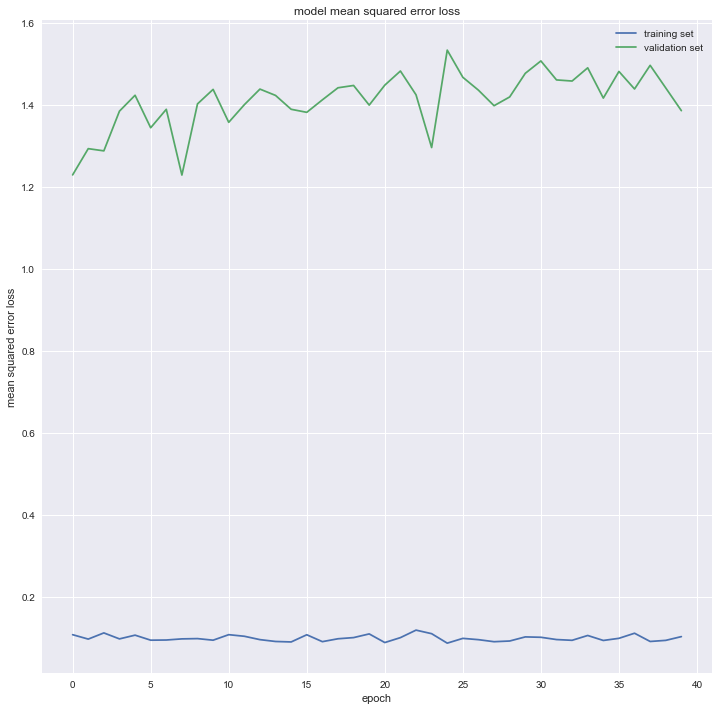

In [29]:
plt.figure(figsize=(12,12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


#### Confusion Matrix

Log loss: 3.7944724104760645
Accuracy: 0.8044871794871795


/Users/dibakarsigdel/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


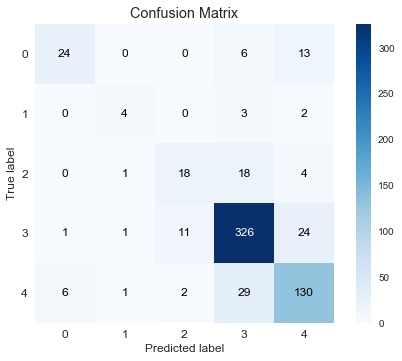

In [31]:
probas = model.predict(X_test)
pred_indices = np.argmax(probas, axis=1)
classes = np.unique(y_test)
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(y_test, probas)))
print('Accuracy: {}'.format(accuracy_score(y_test, preds)))
skplt.plot_confusion_matrix(y_test, preds)